## Data Science Crash Course: Predicting Credit Card Application Approvals

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import *
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

For my thesis, I wanted to build a classification model to predict the approval of a credit card application based on the information (income, credit score, citizenship, etc...) that the applicant provides. This was really intriguing to me because when I first applied for my credit card, my understanding was that approval was only based on factors such as income and credit score, but this project could potentially find correlations between other factors beyond my current predictions/beliefs. 


I found a cleaned version of this dataset on Kaggle (https://www.kaggle.com/datasets/samuelcortinhas/credit-card-approval-clean-data) which was originally found on the UCI Machine Learning Repository.


In [51]:
'''import dataset'''

credit = pd.read_csv('clean_dataset.csv')
credit.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


In [52]:
print(credit.columns)

Index(['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'Industry',
       'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore',
       'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'Approved'],
      dtype='object')


## Correlation Heatmap

Below, I plotted a correlation heatmap with all the variables within the dataset to see their initial relationships and correlations with each other.

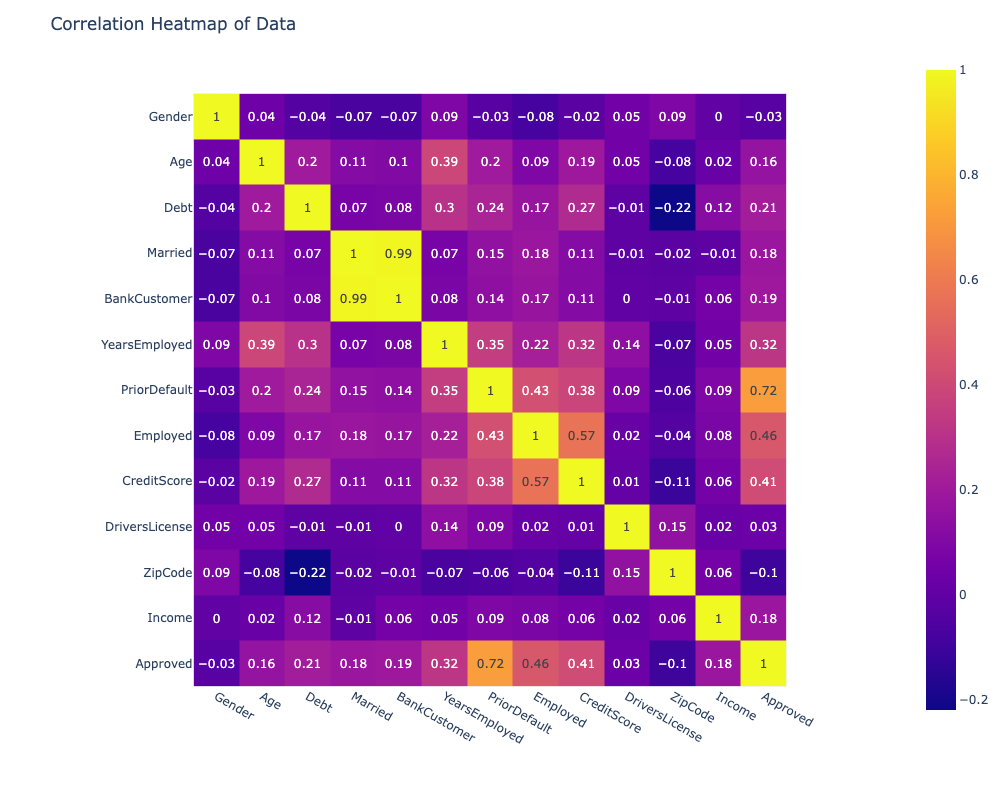

In [104]:
corr = credit.corr()
corr_rounded = np.around(corr, 2)
fig = px.imshow(corr_rounded, text_auto = True)
fig.update_layout(
    width = 800, 
    height = 800,
    title_text = 'Correlation Heatmap of Data'
)
fig.show()
fig.write_html('Correlation Heatmap')

## Exploratory Data Analysis

Because we have don't have much information about all of the features and how they interact with one another, we will perform exploratory data analysis to understand these relationships further.

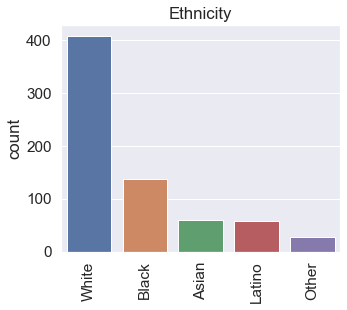

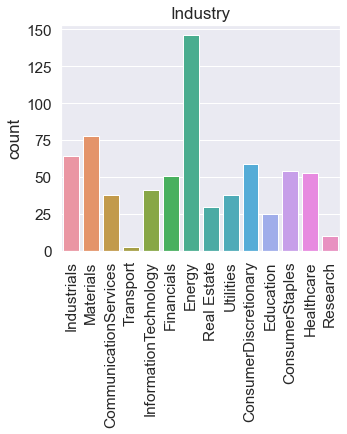

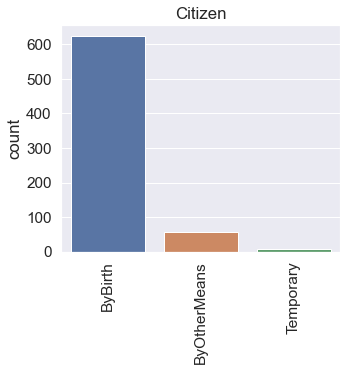

In [54]:
#visualize the counts of categorical variables
cat_col = ['Ethnicity', 'Industry', 'Citizen']

for index, plot in enumerate(cat_col):
    f = plt.figure(figsize=(5, 15))
    plt.subplot(3, 1, index + 1)
    sns.countplot(x = plot, data = credit)
    plt.xticks(rotation = 90)
    plt.xlabel('')
    plt.title(str(plot))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

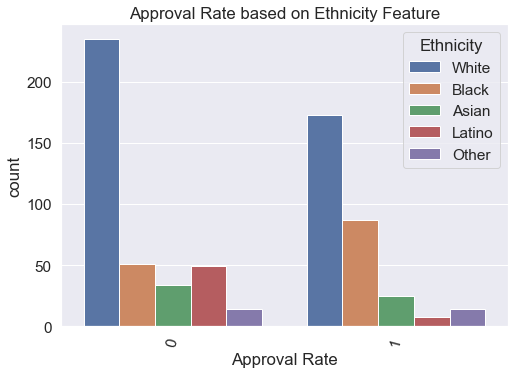

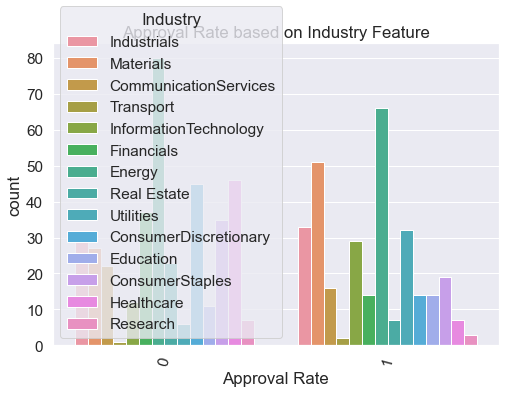

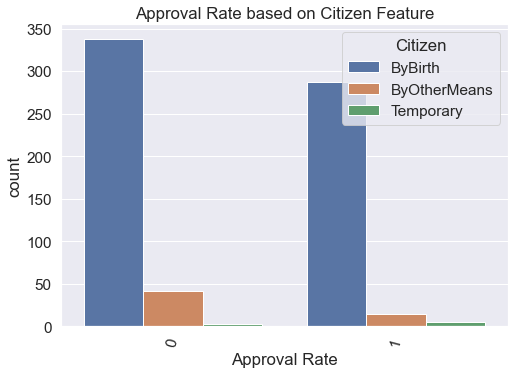

In [55]:
#understanding the impact of each categorical column on the approval rate
cat_col = ['Ethnicity', 'Industry', 'Citizen']

for index, plot in enumerate(cat_col):
    f = plt.figure(figsize=(8, 20))
    plt.subplot(3, 1, index + 1)
    sns.countplot(x = "Approved", data = credit, hue = plot)
    plt.xticks(rotation = 75)
    plt.xlabel('Approval Rate')
    plt.title('Approval Rate based on ' + str(plot) + ' Feature')
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

Because industry does not seem to have a strong impact on the approval rate, we will be excluding this from our machine learning models. This is also the case with the citizen feature. However, I think it would be important to include the ethnicity feature for our approval classification. It brings up an additional hypothesis that ethnicity could have a possible impact on the approval of credit card applications which bring up more significant questions of racial bias in the application process.


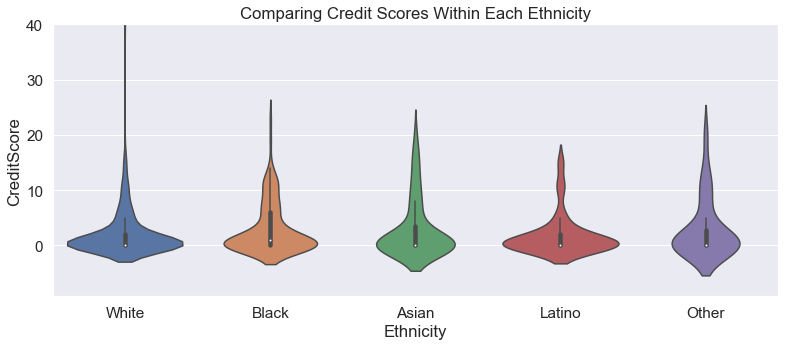

In [56]:
#making a violin plot to see the distributions of credit scores within each ethinicity
fig, ax = plt.subplots(figsize=(13,5)) 
sns.violinplot(x = 'Ethnicity', y = 'CreditScore', data = credit) #note that the column credit score has been scaled
plt.ylim(top = 40)
plt.title('Comparing Credit Scores Within Each Ethnicity');

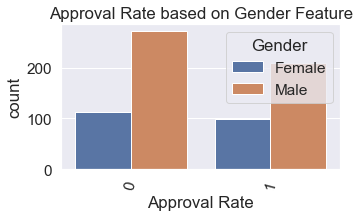

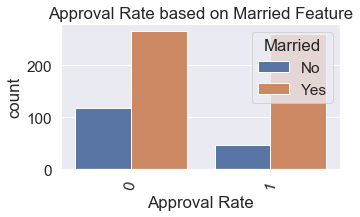

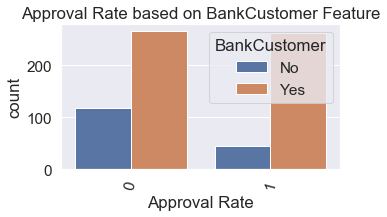

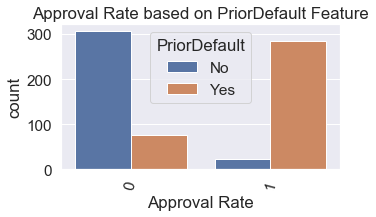

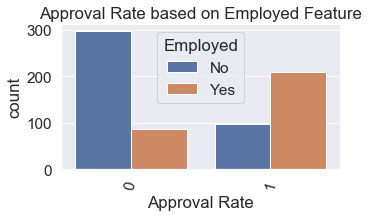

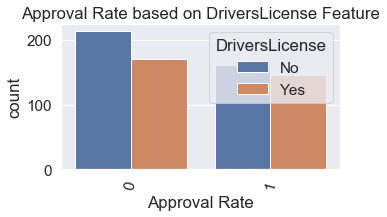

In [57]:
#visualize approval rates by each binary column
bin_col = ['Gender', 'Married', 'BankCustomer', 'PriorDefault', 'Employed', 'DriversLicense']

for index, plot in enumerate(bin_col):
    f = plt.figure(figsize=(5, 20))
    plt.subplot(len(bin_col), 1, index + 1)
    sns.countplot(x = 'Approved', data = credit, hue = plot)
    plt.xticks(rotation = 75)
    plt.xlabel('Approval Rate')
    plt.title('Approval Rate based on ' + str(plot) + ' Feature')
    #plt.legend(['Rejected', 'Approved'])
    if plot == 'Gender':
        plt.legend(['Female', 'Male'], title = plot)
    else:
        plt.legend(['No', 'Yes'], title = plot)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

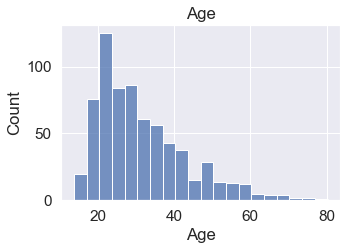

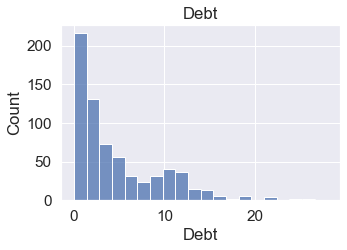

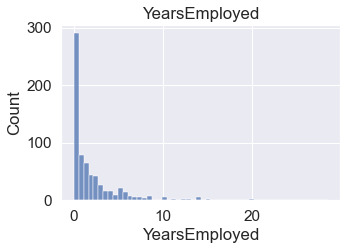

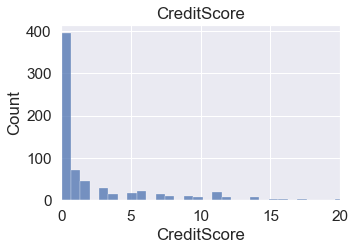

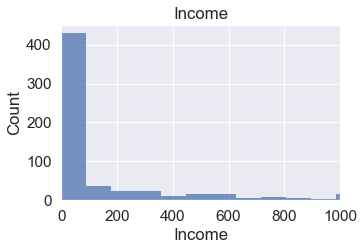

In [58]:
#understanding the impact of each numerical column on the approval rate
num_col = ['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'Income']

for index, plot in enumerate(num_col):
    f = plt.figure(figsize=(5, 20))
    plt.subplot(len(num_col), 1, index + 1)
    sns.histplot(x = plot, data = credit)
    if plot == 'CreditScore':
        plt.xlim([0, 20])
    if plot == 'Income':
        plt.xlim([0, 1000])
    plt.title(str(plot))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

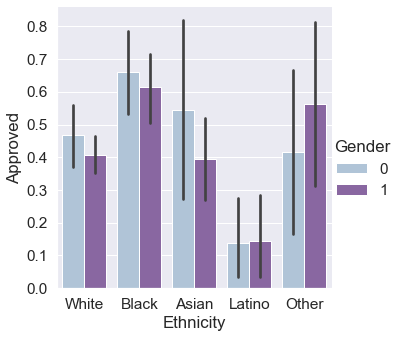

In [59]:
sns.catplot(data = credit, kind = 'bar', x = 'Ethnicity', y = 'Approved', hue = 'Gender', palette = 'BuPu');
#gender variable: 0 ~ female, 1 ~ male

### Data Engineering

After doing initial data analysis, I will be excluding the variables 'DriversLicense', 'ZipCode', and 'Citizen' from my dataset and in the following ML models. I also do not need to scale any other variables as the dataset that I found on Kaggle was already cleaned and standardized for easy use.

In [95]:
new_credit = credit.drop(labels = ['Age','Gender','Ethnicity','ZipCode', 'Citizen', 'Industry', 'DriversLicense'], axis = 1)
new_credit

,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,Income,Approved
0,0.000,1,1,1.25,1,1,1,0,1
1,4.460,1,1,3.04,1,1,6,560,1
2,0.500,1,1,1.50,1,0,0,824,1
3,1.540,1,1,3.75,1,1,5,3,1
4,5.625,1,1,1.71,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
685,10.085,0,0,1.25,0,0,0,0,0
686,0.750,1,1,2.00,0,1,2,394,0
687,13.500,0,0,2.00,0,1,1,1,0
688,0.205,1,1,0.04,0,0,0,750,0


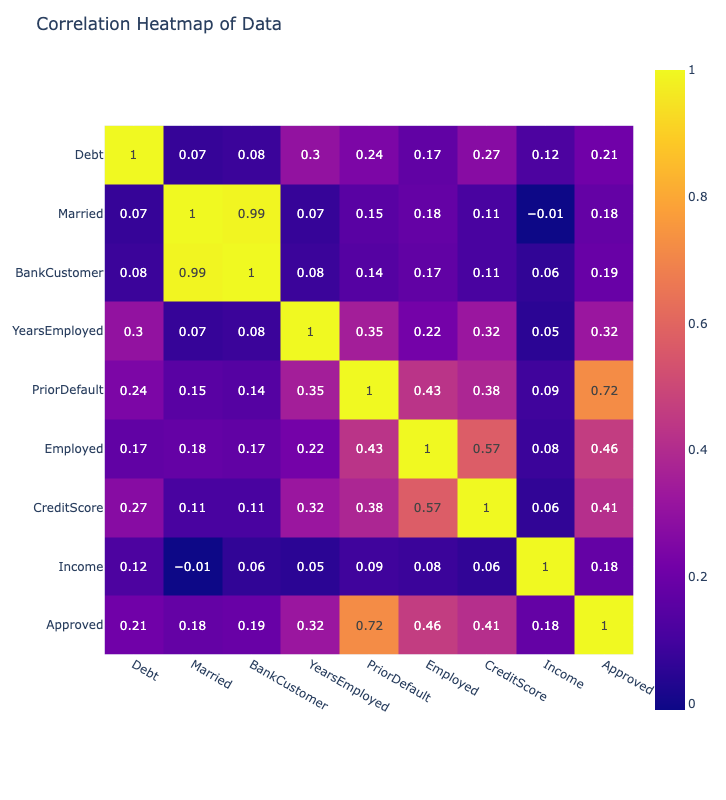

In [105]:
corr = new_credit.corr()
corr_rounded = np.around(corr, 2)
fig = px.imshow(corr_rounded, text_auto = True)
fig.update_layout(
    width = 800, 
    height = 800,
    title_text = 'Correlation Heatmap of Data'
)
fig.show()
fig.write_html('c-map2')

### Machine Learning

In [107]:
#split up features and target variable and perform a train test split
features = np.array(new_credit.drop(['Approved'], axis = 1).columns)
X = new_credit.loc[:, features]
y = np.array(new_credit['Approved'])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state = 42, train_size = 0.75)

### Logistic Regression

In [167]:
#create linear regression model
lr = linear_model.LogisticRegression(random_state = 42)

#fit on training data
lr.fit(X_train, y_train)

#predict fitted model on test (unseen) data
y_pred = lr.predict(X_test)

#print test accuracy
print('Accuracy of Logistic Regression: ' + str(metrics.accuracy_score(y_pred, y_test)))

#calculate mean absolute error
print('Mean Absolute Error: ' + str(metrics.mean_absolute_error(y_pred, y_test)))

Accuracy of Logistic Regression: 0.838150289017341
Mean Absolute Error: 0.16184971098265896


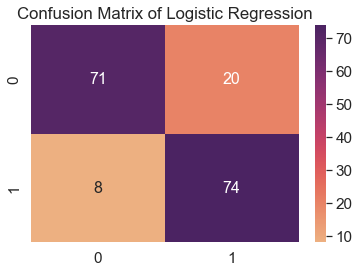

In [168]:
#plot confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap = 'flare')
plt.title('Confusion Matrix of Logistic Regression');

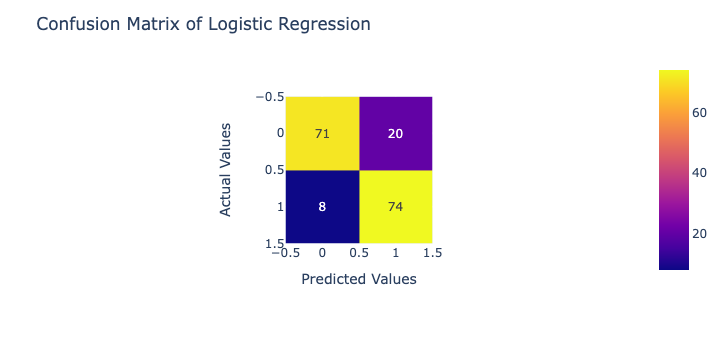

In [169]:
x = ['Rejected', 'Approved']
y = ['Approved', 'Rejected']
fig = px.imshow(cm, text_auto = True)
fig.update_layout(
    title_text = 'Confusion Matrix of Logistic Regression',
    xaxis={'title': 'Predicted Values'}, 
    yaxis={'title': 'Actual Values'}
)
fig.show()
fig.write_html('cf-lr')

### k-Nearest Neighbors

In [170]:
#create knn classifier
classifier = neighbors.KNeighborsClassifier(n_neighbors = 5)

#fit on training set
classifier.fit(X_train, y_train)

#predict on test (unseen) data
y_pred = classifier.predict(X_test) 

#print accuracy
print('Accuracy of k-Nearest Neighbors Classifier: ' + str(metrics.accuracy_score(y_pred, y_test)))

#calculate mean absolute error
print('Mean Absolute Error: ' + str(metrics.mean_absolute_error(y_pred, y_test)))

Accuracy of k-Nearest Neighbors Classifier: 0.7225433526011561
Mean Absolute Error: 0.2774566473988439


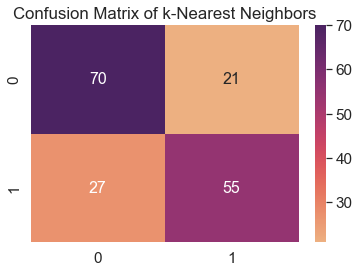

In [171]:
#plot confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap = 'flare')
plt.title('Confusion Matrix of k-Nearest Neighbors');

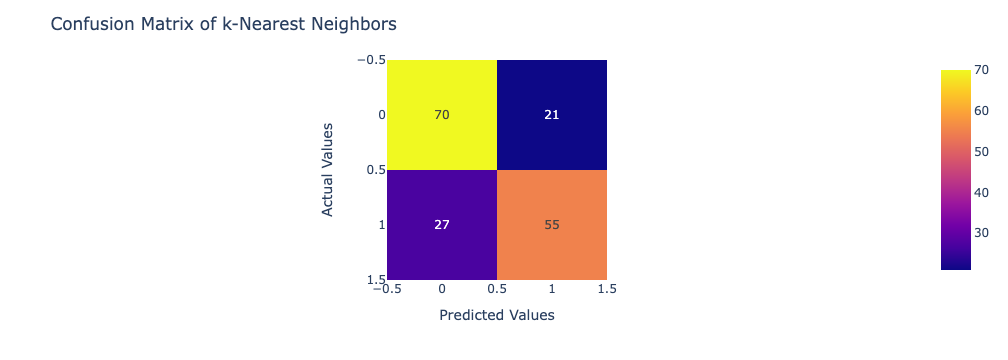

In [172]:
x = ['Rejected', 'Approved']
y = ['Approved', 'Rejected']
fig = px.imshow(cm, text_auto = True)
fig.update_layout(
    title_text = 'Confusion Matrix of k-Nearest Neighbors',
    xaxis={'title': 'Predicted Values'}, 
    yaxis={'title': 'Actual Values'}
)
fig.show()
fig.write_html('cf-knn')

### Random Forests

In [173]:
#create random forest
rf = ensemble.RandomForestClassifier(n_estimators = 100)

#fit on training set
rf.fit(X_train, y_train)

#predict on test (unseen) data
y_pred = rf.predict(X_test)

#print accuracy
print('Accuracy of Random Forest Classifier: ' + str(metrics.accuracy_score(y_pred, y_test)))

#calculate mean absolute error
print('Mean Absolute Error: ' + str(metrics.mean_absolute_error(y_pred, y_test)))

Accuracy of Random Forest Classifier: 0.8554913294797688
Mean Absolute Error: 0.14450867052023122


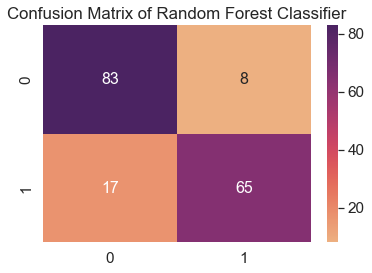

In [174]:
#plot confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap = 'flare')
plt.title('Confusion Matrix of Random Forest Classifier');

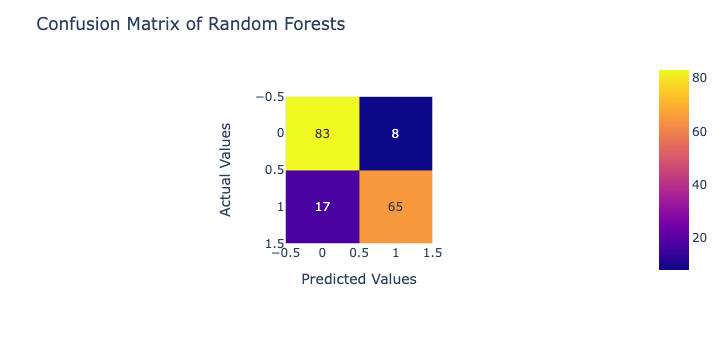

In [175]:
x = ['Rejected', 'Approved']
y = ['Approved', 'Rejected']
fig = px.imshow(cm, text_auto = True)
fig.update_layout(
    title_text = 'Confusion Matrix of Random Forests',
    xaxis={'title': 'Predicted Values'}, 
    yaxis={'title': 'Actual Values'}
)
fig.show()
fig.write_html('cf-rf')